In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import tensorflow as tf
import keras

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [3]:
model = keras.models.Sequential([
    keras.layers.Reshape((28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(1, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(1, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(10)
])

opt = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [4]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 2.1434 - accuracy: 0.2318 - val_loss: 1.6634 - val_accuracy: 0.4282
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.5479 - accuracy: 0.4598 - val_loss: 1.4606 - val_accuracy: 0.4985
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 1.4353 - accuracy: 0.5098 - val_loss: 1.3624 - val_accuracy: 0.5323
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3534 - accuracy: 0.5371 - val_loss: 1.2895 - val_accuracy: 0.5518
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2965 - accuracy: 0.5569 - val_loss: 1.2398 - val_accuracy: 0.5700
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2669 - accuracy: 0.5681 - val_loss: 1.2173 - val_accuracy: 0.5846
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 1.2531 - accuracy: 0.5731 - val_loss: 1.2062 - val_accuracy:

In [5]:
from HGQ.layers import HDense, HConv2D, PMaxPooling2D, PFlatten, PReshape, HQuantize
from HGQ import ResetMinMax, FreeBOPs
from HGQ import trace_minmax, to_proxy_model

In [6]:
model = keras.models.Sequential([
    HQuantize(beta=3e-5),
    PReshape((28, 28, 1)),
    PMaxPooling2D((2, 2)),
    HConv2D(1, (3, 3), activation='relu', beta=3e-5, parallel_factor=144),
    PMaxPooling2D((2, 2)),
    HConv2D(1, (3, 3), activation='relu', beta=3e-5, parallel_factor=16),
    PMaxPooling2D((2, 2)),
    PFlatten(),
    HDense(10, beta=3e-5)
])

opt = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
callbacks = [ResetMinMax(), FreeBOPs()]

In [7]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/10
1875/1875 [==============================] - 13s 5ms/step - loss: 2.2821 - accuracy: 0.2814 - val_loss: 1.9375 - val_accuracy: 0.4598 - bops: 11193.0000
Epoch 2/10
1875/1875 [==============================] - 8s 5ms/step - loss: 1.8053 - accuracy: 0.5249 - val_loss: 1.6885 - val_accuracy: 0.5653 - bops: 12571.0000
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.6504 - accuracy: 0.5586 - val_loss: 1.5659 - val_accuracy: 0.5750 - bops: 10586.0000
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.6043 - accuracy: 0.5672 - val_loss: 1.5449 - val_accuracy: 0.5857 - bops: 10949.0000
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.5919 - accuracy: 0.5653 - val_loss: 1.5357 - val_accuracy: 0.5931 - bops: 10845.0000
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 1.5724 - accuracy: 0.5715 - val_loss: 1.5279 - val_accuracy: 0.5969 - bops: 10992.0000
Epoch 7/10
1875/1875 

In [8]:
trace_minmax(model, x_train, cover_factor=1.0)
# BOPs computed during training is overestimated in general. The number obtained here is more accurate.

h_quantize: 0.0
h_conv2d: 3619.0
h_conv2d_1: 1168.0
h_dense: 581.0


5368.0

In [9]:
proxy = to_proxy_model(model, aggressive=True)

In [10]:
from hls4ml.converters import convert_from_keras_model

/home/calad/repo/hls4ml/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


In [21]:
model_hls = convert_from_keras_model(proxy, backend='vivado',output_dir='/tmp/mnist_hls',part='xcvu9p-flga2104-2L-e')

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 28, 28]], output shape: [None, 28, 28]
Layer name: h_quantize_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 28, 28]], output shape: [None, 28, 28]
Layer name: p_reshape, layer type: Reshape, input shapes: [[None, 28, 28]], output shape: [None, 28, 28, 1]
Layer name: p_max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 14, 14, 1]
Layer name: h_conv2d, layer type: Conv2D, input shapes: [[None, 14, 14, 1]], output shape: [None, 12, 12, 1]
Layer name: h_conv2d_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 12, 12, 1]], output shape: [None, 12, 12, 1]
Layer name: h_conv2d_relu, layer type: Activation, input shapes: [[None, 12, 12, 1]], output shape: [None, 12, 12, 1]
Layer name: h_conv2d_relu_quantizer, layer type: FixedPointQuantizer, input shapes: [[None, 12, 12, 1]], output shape: [None, 12, 12, 1]
Layer name:

In [22]:
model_hls.compile()

Writing HLS project
Done


In [23]:
r_keras = model(x_test).numpy()
r_proxy = proxy(x_test).numpy()
r_hls = model_hls.predict(x_test)

In [24]:
import numpy as np

In [25]:
assert np.all(r_proxy == r_hls)

In [26]:
np.sum(r_keras != r_hls)

1

In [27]:
from matplotlib import pyplot as plt

In [28]:
bw = model.layers[0].act_bw.numpy()

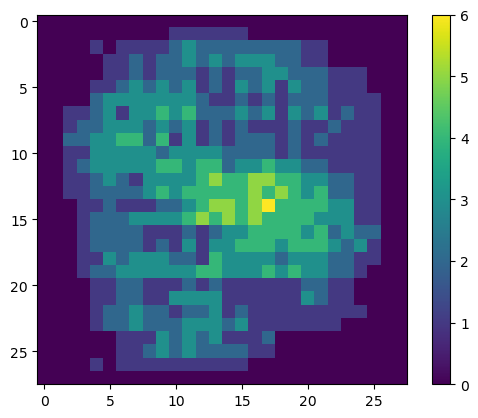

In [29]:
plt.imshow(bw[0])
plt.colorbar()
plt.show()

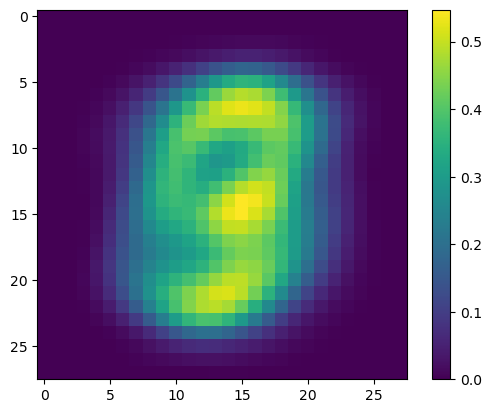

In [30]:
plt.imshow(np.mean(x_train, axis=0))
plt.colorbar()
plt.show()